In [1]:
# Attempt to solve QOSF monthly challenge march 2022 Task 1: https://github.com/qosf/monthly-challenges/blob/main/challenge-2022.03-mar/challenge-2022.03-mar.ipynb
import math
from collections import Counter

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector

from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit.circuit.library import GroverOperator, ZGate
from qiskit.algorithms import AmplificationProblem

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.algorithms import Grover
from qiskit import Aer

# provider = IBMQ.load_account()

/Users/sahmoud/Library/Python/3.9/lib/python/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


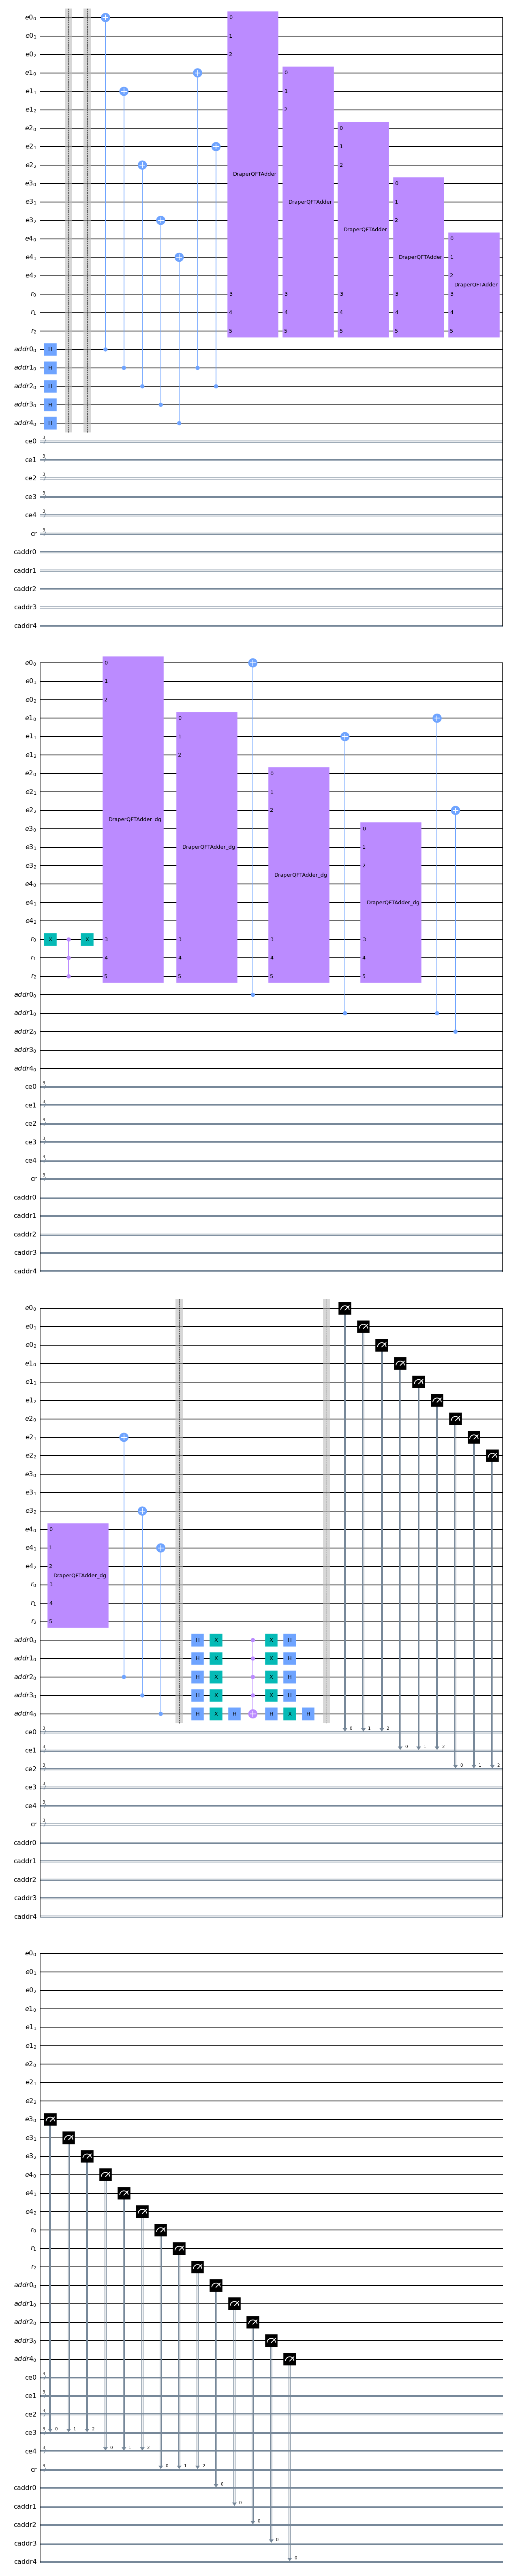

In [2]:
def get_registers(n, B):
    qregs=[] # quantum registers
    cregs=[] # classical registers
    for i in range(n):
        qregs.append(QuantumRegister(B, "e"+str(i)))
        cregs.append(ClassicalRegister(B, "ce"+str(i)))
    qregs.append(QuantumRegister(B, "r")) # result qubit
    cregs.append(ClassicalRegister(B, "cr")) # result qubit
    for i in range(n):
        qregs.append(QuantumRegister(1, "addr"+str(i)))
        cregs.append(ClassicalRegister(1, "caddr"+str(i)))
    
    return qregs, cregs

def set_values(c, arr, B, n, qregs):
    for i in range(len(arr)):
        val = arr[i]
        bin_val = bin(val)[2:]
        # do some padding
        bin_val = "0"*(B-len(bin_val))+bin_val
        ctrl = B*(n+1)+i
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "1":
                c.cx(ctrl,qregs[i][B-j-1])

# q1=[0,1]
# q2=[6,7]
def add(c, B, q1, q2, sign):
    draper_circ = DraperQFTAdder(B)
    if sign == 1:
        c = c.compose(draper_circ, list(q1) + list(q2))
    elif sign == -1:
        c = c.compose(draper_circ.inverse(), list(q1) + list(q2))
    return c

def add_all(c, n, B, R, sign):
    for i in range(n):
        c = add(c, B, range(i*B, (i+1)*B), R, sign)
    return c

def apply_h_on_address(c, n, qregs):
    for i in range(n):
        c.h(qregs[n+1+i])

def grovers_shit(c, n, B, R, target_sum, grover_iterations, qregs):
    # GET THE ORACLE
    oracle = QuantumCircuit(*qregs)
    # part 2 set values
    set_values(oracle, arr, B, n, qregs)
    # part 3 sum
    oracle = add_all(oracle, n, B, R, 1)
    # part 4 check
    t_bin = bin(target_sum)[2:]
    t_bin = "0"*(B-len(t_bin))+t_bin
    for i, bin_digit in enumerate(t_bin):
        if bin_digit == "0":
            oracle.x(n*B+B-i-1)
    oracle.append(ZGate().control(B-1), range(n*B,n*B+B))
    for i, bin_digit in enumerate(t_bin):
        if bin_digit == "0":
            oracle.x(n*B+B-i-1)
    # part 5 uncompute sum
    oracle = add_all(oracle, n, B, R, -1)
    # part 6 CNOT dagger = CNOT
    set_values(oracle, arr, B, n, qregs)

    # Now build the Diffuser
    diffuser = QuantumCircuit(n) # just the address qubits
    for j in range(n):
        diffuser.h(j)
        diffuser.x(j)
    LAST = n-1
    diffuser.h(LAST)
    # ccnot (multi control Tofolli gate)
    diffuser.mct(list(range(0, n-1)), LAST)
    diffuser.h(LAST)
    for j in range(n):
        diffuser.x(j)
        diffuser.h(j)
    
    for i in range(grover_iterations):
        c.barrier()
        c = c.compose(oracle)
        c.barrier()
        c = c.compose(diffuser, range(n*B+B, n*B+B+n))
        
    
    # c = c.compose(oracle)
    return c
    
def get_circ(arr, B, target_sum, grover_iterations):
    n = len(arr)
    addr=[0]*n
    R = list(range(n*B, n*B+B))
    qregs, cregs = get_registers(n, B)
    c = QuantumCircuit(*qregs, *cregs)
    apply_h_on_address(c, n, qregs)
    c.barrier()
    # GROVERS SHIT
    c = grovers_shit(c, n, B, R, target_sum, grover_iterations, qregs)
    c.barrier()
    c.measure(range(B*(n+1)+n), range(B*(n+1)+n))
    return c

# arr = [2,1,3]
# 110 -> 011
# 001 -> 100
arr = [1,3,6,4,2]
# 11001 -> 10011
# 00100 -> 00100
# 00011 -> 11000
# 11110 -> 01111
B = len(bin(max(arr))) - 2 # bit_length
k=3
# N=2**(2*4+3)
N=2**B
grover_iterations = int(math.sqrt(N/k)*math.pi/4)
c = get_circ(arr, B, 6, grover_iterations)
# sv=Statevector.from_label('00'*4+'000')
# sv = sv.evolve(c)"
# print(list(sv.data))
# sv.draw(output='latex')
c.draw('mpl')

[('0 1 1 1 1 000 000 000 000 000 000', 24), ('0 0 1 0 0 000 000 000 000 000 000', 19), ('1 0 0 1 1 000 000 000 000 000 000', 18), ('1 1 0 0 0 000 000 000 000 000 000', 15), ('1 1 0 1 0 000 000 000 000 000 000', 3), ('0 1 1 0 1 000 000 000 000 000 000', 2), ('1 1 1 1 1 000 000 000 000 000 000', 2), ('0 1 1 1 0 000 000 000 000 000 000', 2), ('1 0 0 0 1 000 000 000 000 000 000', 2), ('0 1 0 1 0 000 000 000 000 000 000', 2), ('1 0 0 1 0 000 000 000 000 000 000', 1), ('0 1 1 0 0 000 000 000 000 000 000', 1), ('0 0 0 0 0 000 000 000 000 000 000', 1), ('0 0 1 1 0 000 000 000 000 000 000', 1), ('0 0 1 0 1 000 000 000 000 000 000', 1), ('1 0 0 0 0 000 000 000 000 000 000', 1), ('1 0 1 1 1 000 000 000 000 000 000', 1), ('0 0 0 0 1 000 000 000 000 000 000', 1), ('1 0 1 1 0 000 000 000 000 000 000', 1), ('0 0 0 1 0 000 000 000 000 000 000', 1), ('1 1 1 0 1 000 000 000 000 000 000', 1)]


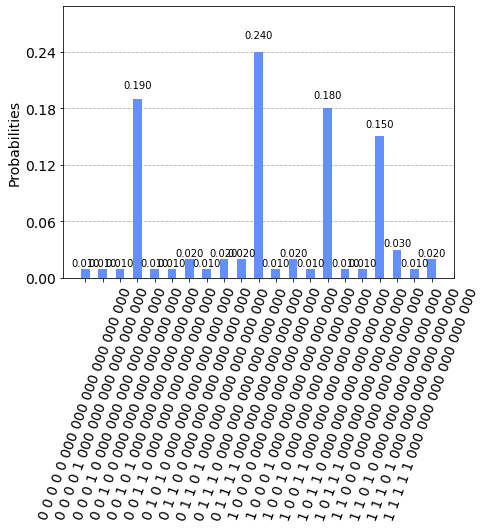

In [4]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 100
results = execute(c, backend=backend, shots=shots).result()
answer = results.get_counts()

print(Counter(answer).most_common())
# print(answer)
plot_histogram(answer)

In [57]:
# [2,1,3]
# 0b01100000000=768+1
# 0b10000000000=1024+1
sv=Statevector.from_label('00')
cnotcirc=QuantumCircuit(2)
cnotcirc.h(0)
cnotcirc.cnot(0,1)
sv.evolve(cnotcirc).draw(output='latex')

# state = qi.Statevector.from_instruction(cnotcirc)
# state.draw(output='latex')

<IPython.core.display.Latex object>